<a href="https://colab.research.google.com/github/saian65/User-Churn/blob/main/user_churn_acc_98%2C4_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
%matplotlib inline

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
events_data = pd.read_csv('event_data_train.csv')

In [ ]:
events_data.head(1)

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632


In [ ]:
events_data.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

In [ ]:
nusers = events_data.user_id.nunique()
nsteps = events_data.step_id.nunique()

In [ ]:
events_data['date'] = pd.to_datetime(events_data.timestamp,unit='s')

In [ ]:
events_data['day'] = events_data.date.dt.date

In [ ]:
events_data.head(1)

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15


In [ ]:
sns.set(rc={'figure.figsize':(20,10)})

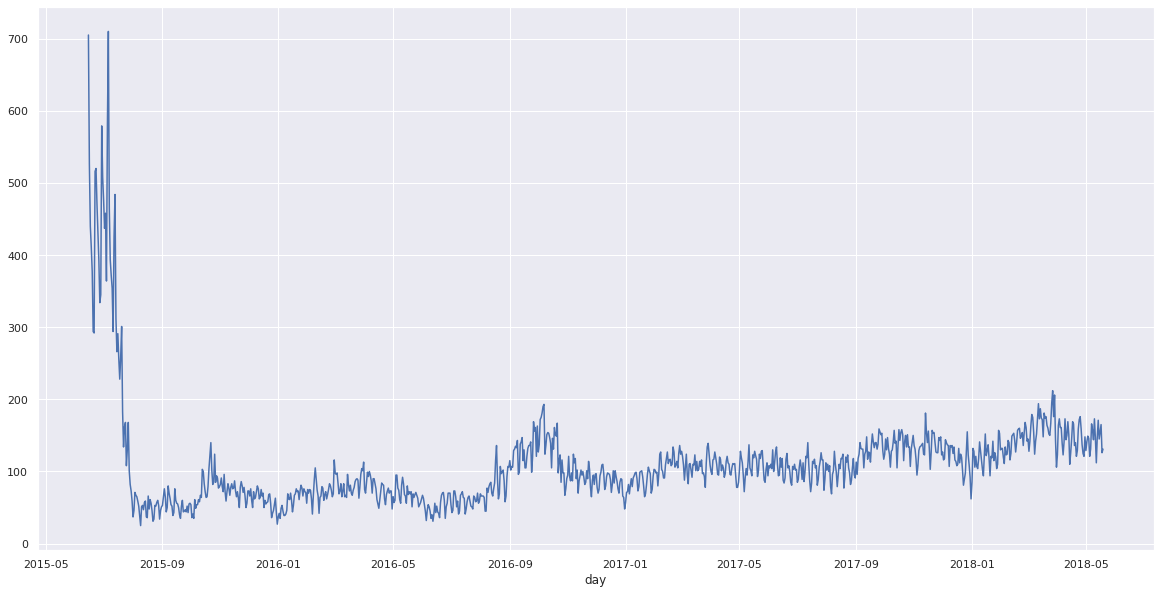

In [ ]:
#сколько уникальных пользователей было по дню
events_data.groupby('day')\
  .user_id.nunique().plot()

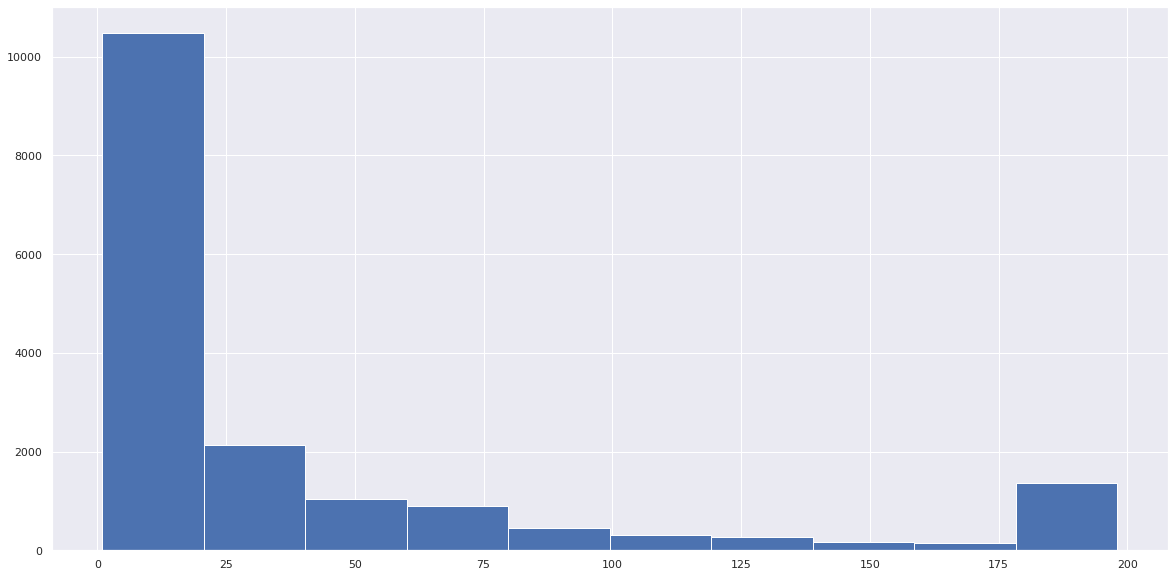

In [ ]:
#посчитано число неуникальных пройденных шагов для каждого пользователя
events_data[events_data.action == 'passed']\
  .groupby('user_id', as_index=False) \
  .agg({'step_id':'count'})\
  .rename(columns={'step_id':'passed_steps'}).passed_steps.hist()

In [ ]:
#для каждого пользователя посчитано число всех видов шагов
events_data.pivot_table(
    index='user_id',
    columns='action',
    values='step_id',
    aggfunc='count',
    fill_value=0
).head()

action,discovered,passed,started_attempt,viewed
user_id,,,,
1,1,0,0,1
2,9,9,2,10
3,91,87,30,192
5,11,11,4,12
7,1,1,0,1


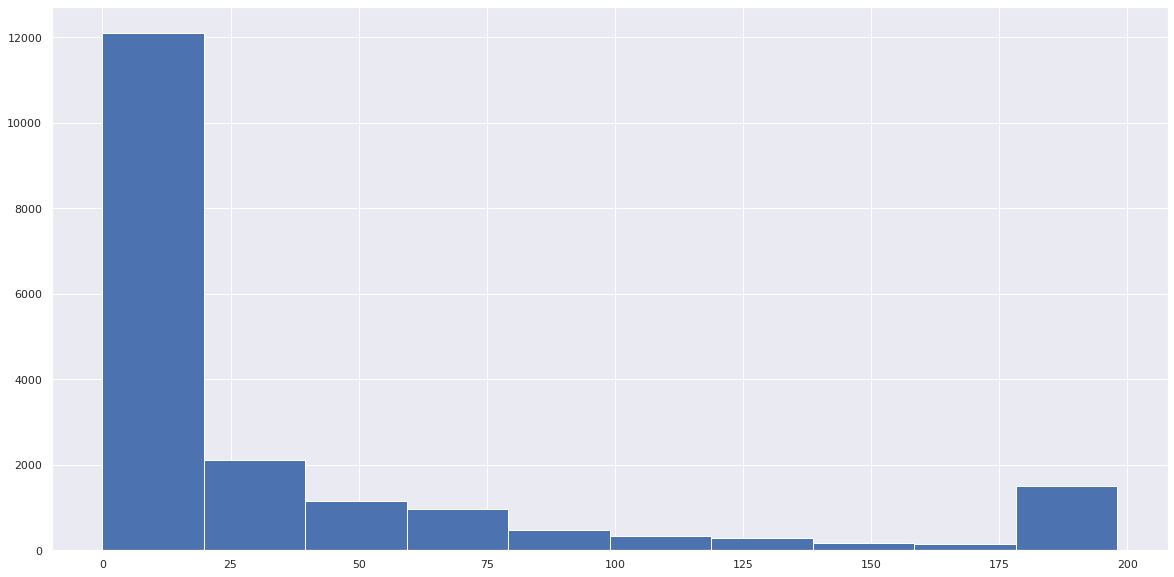

In [ ]:
#примерно 1000 пользователей не сделало ни одного шага в курсе
events_data.pivot_table(
    index='user_id',
    columns='action',
    values='step_id',
    aggfunc='count',
    fill_value=0
).reset_index().discovered.hist()

In [ ]:
submissions_data = pd.read_csv('submissions_data_train.csv')

In [ ]:
submissions_data['date'] = pd.to_datetime(events_data.timestamp,unit='s')
submissions_data['day'] = submissions_data.date.dt.date

In [ ]:
submissions_data.head(1)

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 04:00:48,2015-06-15


In [ ]:
users_scores = submissions_data.pivot_table(
    index = 'user_id',
    columns = 'submission_status',
    values = 'step_id',
    aggfunc = 'count',
    fill_value = 0
).reset_index()

In [ ]:
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [ ]:
#для каждого пользователя дни когда он заходил минимум раз
  events_data[['user_id','day','timestamp']]\
  .drop_duplicates(subset=['user_id','day'])\
  .groupby('user_id')['timestamp'].apply(list)

user_id
1                                             [1472827464]
2                                 [1514383364, 1519226966]
3        [1434358476, 1441257725, 1441440209, 144153391...
5                                 [1466156809, 1499859621]
7                                             [1521634660]
                               ...                        
26790     [1451484016, 1451722241, 1452616205, 1517495853]
26793                                         [1510225031]
26794    [1495287049, 1495373177, 1495509936, 149560483...
26797                             [1508425316, 1509993306]
26798                                         [1520975763]
Name: timestamp, Length: 19234, dtype: object

In [ ]:
#промежутки между этими днями
events_data[['user_id','day','timestamp']]\
.drop_duplicates(subset=['user_id','day'])\
.groupby('user_id')['timestamp']\
.apply(list)\
.apply(np.diff)

user_id
1                                                       []
2                                                [4843602]
3         [6899249, 182484, 93710, 2768870, 171400, 78712]
5                                               [33702812]
7                                                       []
                               ...                        
26790                           [238225, 893964, 64879648]
26793                                                   []
26794    [86128, 136759, 94899, 1422583, 14347289, 5050...
26797                                            [1567990]
26798                                                   []
Name: timestamp, Length: 19234, dtype: object

In [ ]:
 #разница между двумя ближайшими заходами на курс для всех пользователей
 gap_data = events_data[['user_id','day','timestamp']]\
    .drop_duplicates(subset=['user_id','day'])\
    .groupby('user_id')['timestamp']\
    .apply(np.diff).values

In [ ]:
gap_data = pd.Series(np.concatenate(gap_data,axis=0))

In [ ]:
gap_data = gap_data/(24*60*60)

In [ ]:
gap_data.head()

0    56.060208
1    79.852419
2     2.112083
3     1.084606
4    32.047106
dtype: float64

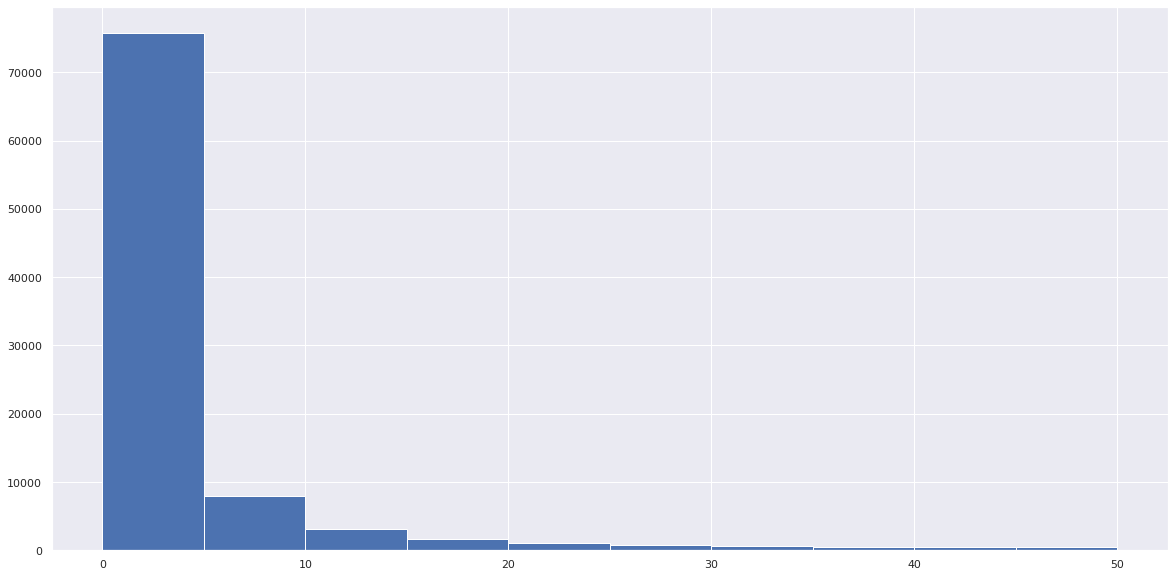

In [ ]:
gap_data[gap_data< 50].hist()

In [ ]:
gap_data.quantile(0.95)
#5 и 10% пользователей возвращается спустя это количество дней. 
#Будем считать что пользователь ушел навсегда если он 
#не появлялся среднее количество дней 
#между этими значениями

59.760440972222156

In [ ]:
gap_data.quantile(0.90)

18.325995370370403

разметка пользователей

In [ ]:
#время последнего заходя для каждого пользователя
events_data.groupby('user_id',as_index=False)\
  .agg({'timestamp':'max'}).head()

,user_id,timestamp
0,1,1472827464
1,2,1519226966
2,3,1444581588
3,5,1499859939
4,7,1521634660


In [ ]:
users_data = events_data.groupby('user_id', as_index=False)\
  .agg({'timestamp': 'max'})\
  .rename(columns={'timestamp':'last_timestamp'})

In [ ]:
30* 24 *60 *60

2592000

In [ ]:
now = 1526772811
dropped = 30* 24 *60 *60

In [ ]:
users_data['is_gone_user'] = (now - users_data.last_timestamp) > dropped

In [ ]:
users_data.user_id.nunique() == nusers

True

In [ ]:
users_scores.user_id.nunique()

9940

In [ ]:
users_data = users_data.merge(users_scores, on='user_id', how='left')

In [ ]:
users_data.user_id.nunique()

19234

In [ ]:
users_data.fillna(0)

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0
...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0
19230,26793,1510225034,True,0.0,0.0
19231,26794,1512035039,True,33.0,9.0
19232,26797,1509995096,True,2.0,0.0


In [ ]:
users_events_data = events_data.pivot_table(
    index='user_id',
    columns='action',
    values='step_id',
    aggfunc='count',
    fill_value=0
).reset_index()

In [ ]:
users_data = users_data.merge(users_events_data, how='outer')

In [ ]:
users_data = users_data.fillna(0)
users_data.user_id.nunique() == nusers

True

In [ ]:
users_data.head(1)

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,0.0,0.0,1,0,0,1


In [ ]:
users_days = events_data.groupby('user_id')\
.day.nunique().to_frame().reset_index()

In [ ]:
users_days.head(1)

,user_id,day
0,1,1


In [ ]:
users_data = users_data.merge(users_days, how='outer')
users_data.user_id.nunique() == nusers

True

In [ ]:
users_data.head(1)

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1


In [ ]:
events_data.user_id.nunique()

19234

In [ ]:
users_data.user_id.nunique()

19234

In [ ]:
users_data['passed_course'] = users_data.passed > 170

In [ ]:
users_data.head(1)

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False


In [ ]:
users_data.groupby('passed_course').count()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
passed_course,,,,,,,,,,
False,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809
True,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425


In [ ]:
#7,4% закончили курс
100 * 1425	/ (17809+1425)

7.408755329104711

In [ ]:
users_data[users_data.passed_course].day.median()

20.0

In [ ]:
user_min_time = events_data.groupby('user_id',as_index=False)\
.agg({'timestamp':'min'})\
.rename(columns={'timestamp':'min_timestamp'})
user_min_time.head(1)

,user_id,min_timestamp
0,1,1472827464


In [ ]:
users_data = users_data.merge(user_min_time,on='user_id',how='left')

In [ ]:
users_data.shape

(19234, 12)

In [ ]:
#промежуток времени который рассматривается при предсказании класса пользователя
learning_time = 3*24*60*60
learning_time

259200

In [ ]:
event_data_train = events_data\
.merge(users_data[['user_id', 'min_timestamp']], on='user_id', how='left') \
.query("(timestamp - min_timestamp) < (3 * 24 * 60 * 60)")

In [ ]:
event_data_train.shape

(1014979, 7)

In [ ]:
event_data_train.groupby('user_id').day.nunique().max()

4

In [ ]:
user_min_time.head(1)

,user_id,min_timestamp
0,1,1472827464


In [ ]:
submissions_data.shape

(509103, 6)

In [ ]:
submissions_data = submissions_data.merge(user_min_time, on='user_id', how='outer')
submissions_data['users_time'] = submissions_data['timestamp'] - submissions_data['min_timestamp']
submissions_data_train = submissions_data[submissions_data.users_time <= 3*24*60*60]
submissions_data_train.groupby('user_id')\
.day.nunique()\
.max()


2

In [ ]:
submissions_data.shape

(518397, 8)

In [ ]:
X = submissions_data_train.groupby('user_id').day.nunique().to_frame().reset_index()

In [ ]:
steps_tried = submissions_data_train.groupby('user_id').step_id\
.nunique().to_frame().reset_index()\
.rename(columns={'step_id':'steps_tried'})

In [ ]:
X = X.merge(steps_tried,on='user_id',how='outer')

In [ ]:
X.shape

(8913, 3)

In [ ]:
X = X.rename(columns={'day':'days'})

In [ ]:
X.head(3)

,user_id,days,steps_tried
0,2,1,2
1,3,1,4
2,8,1,11


In [ ]:
users_scores.head(1)

submission_status,user_id,correct,wrong
0,2,2,0


In [ ]:
X = X.merge(users_scores,how='left',on='user_id')  

In [ ]:
X['right_answ_ratio'] = X['correct']/(X['correct']+X['wrong'])

In [ ]:
count_actions = events_data.pivot_table(
    index='user_id',
    columns='action',
    values='step_id',
    aggfunc='count',
    fill_value=0
).reset_index()[['user_id','viewed']]

In [ ]:
X = X.merge(count_actions,how='outer',on='user_id')

In [ ]:
X=X.fillna(0)

In [ ]:
X.shape

(19234, 7)

In [ ]:
users_data.head(1)

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464


In [ ]:
X.head(1)

,user_id,days,steps_tried,correct,wrong,right_answ_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.0,10


In [ ]:
X = X.merge(users_data[['passed_course','is_gone_user','user_id']],how='outer',on='user_id')

In [ ]:
X.user_id.nunique()

19234

In [ ]:
X = X[~((X.is_gone_user == False) &(X.passed_course == False))]

In [ ]:
y = X.passed_course.map(int)
X = X.set_index(X.user_id)
X.drop(columns=['passed_course','is_gone_user','user_id'],inplace=True)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from sklearn.model_selection import GridSearchCV
model_RandomForest = RandomForestClassifier()
parameters= [{'max_features':[5,6,7],
              'max_depth':[3,6,7],
              'n_estimators':[50,100,200],
              'min_samples_split':[20,25,28],
              'min_samples_leaf':[18,20,25,30]}]
grid_search_RandomForest = GridSearchCV(model_RandomForest,parameters,cv=5)
grid_search_RandomForest.fit(X,y)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 459, in fit
    for i, t in enumerate(trees)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.7/dist-packages/joblib/

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [3, 6, 7], 'max_features': [5, 6, 7],
                          'min_samples_leaf': [18, 20, 25, 30],
                          'min_samples_split': [20, 25, 28],
                          'n_estimators': [50, 100, 200]}])

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(model_RandomForest, X, y, cv=5).sum()/5

0.9844870725604672